In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
# configure df options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

### Read in cleaned dataset  
To obtain station list sorted by numbers of samples

In [3]:
df = pd.read_csv('../../dataset/final/bentre-cleaned.csv', parse_dates=['date'])

In [4]:
# number of stations
station_count_df = df['code'].value_counts()

station_count_df

SONDOC             2271
LOCTHUAN           2154
BENTRAI            2108
BINHDAI            2108
ANTHUAN            2108
TIENTHUY            302
PHUOCLONG           302
TANTHIENG           302
MOCAY               302
MYHOA               212
GIAOHOA             182
THANHTHOIA          151
MYTHANH             151
VANGQUOITAY         151
CAMSON              151
HUNGKHANHTRUNGB     151
SONPHU              151
CAIMIT              151
HUONGMY              92
Name: code, dtype: int64

### Load 2002 - 2018 samples from all stations

In [5]:
# where all CSV files are
input_path = '../../dataset/final/stations_all'

In [6]:
def read_csv(filename):
    return pd.read_csv(filename, usecols=['date', 'code', 'min', 'max'], index_col='date', parse_dates=['date'])

In [7]:
path = Path(input_path)

for index, file in enumerate(path.rglob('*.csv')):
    if index == 0:
        df = read_csv(file)
        count = df.shape[0]
    else:
        temp = read_csv(file)
        count = temp.shape[0]
        
        df = pd.concat([df, temp])
                        
    print(f'{index + 1}. Processing {count} rows from file: {file}')

1. Processing 6209 rows from file: ../../dataset/final/stations_all/THANHTHOIA.csv
2. Processing 6209 rows from file: ../../dataset/final/stations_all/BINHDAI.csv
3. Processing 6209 rows from file: ../../dataset/final/stations_all/BENTRAI.csv
4. Processing 6209 rows from file: ../../dataset/final/stations_all/MYHOA.csv
5. Processing 6209 rows from file: ../../dataset/final/stations_all/SONPHU.csv
6. Processing 6209 rows from file: ../../dataset/final/stations_all/CAMSON.csv
7. Processing 6209 rows from file: ../../dataset/final/stations_all/MYTHANH.csv
8. Processing 6209 rows from file: ../../dataset/final/stations_all/TANTHIENG.csv
9. Processing 6209 rows from file: ../../dataset/final/stations_all/CAIMIT.csv
10. Processing 6209 rows from file: ../../dataset/final/stations_all/MOCAY.csv
11. Processing 6209 rows from file: ../../dataset/final/stations_all/PHUOCLONG.csv
12. Processing 6209 rows from file: ../../dataset/final/stations_all/ANTHUAN.csv
13. Processing 6209 rows from file: .

In [8]:
df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=117971, freq=None)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117971 entries, 2002-01-01 to 2018-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   code    117971 non-null  object 
 1   min     117971 non-null  float64
 2   max     117971 non-null  float64
dtypes: float64(2), object(1)
memory usage: 3.6+ MB


In [10]:
df.sort_index(inplace=True)

In [11]:
df.head(20)

,code,min,max
date,,,
2002-01-01,THANHTHOIA,0.01000,0.01000
2002-01-01,HUNGKHANHTRUNGB,0.01000,0.01000
2002-01-01,BINHDAI,0.50000,2.00000
2002-01-01,SONDOC,0.10000,0.30000
2002-01-01,CAMSON,0.01000,0.01000
2002-01-01,LOCTHUAN,0.01000,0.01000
2002-01-01,SONPHU,0.01000,0.01000
2002-01-01,TIENTHUY,0.01000,0.01000
2002-01-01,MYTHANH,0.01000,0.01000


In [12]:
df.tail(20)

,code,min,max
date,,,
2018-12-30,TANTHIENG,0.01000,0.01000
2018-12-31,TIENTHUY,0.01000,0.01000
2018-12-31,BINHDAI,0.01000,0.01000
2018-12-31,HUONGMY,0.01000,0.01000
2018-12-31,SONPHU,0.01000,0.01000
2018-12-31,VANGQUOITAY,0.01000,0.01000
2018-12-31,BENTRAI,0.01000,0.01000
2018-12-31,ANTHUAN,0.01000,0.01000
2018-12-31,MYTHANH,0.01000,0.01000


### Trend and cyclical components

In [13]:
import statsmodels.api as sm

In [14]:
min_cycle, min_trend = sm.tsa.filters.hpfilter(df['min'])
max_cycle, max_trend = sm.tsa.filters.hpfilter(df['max'])

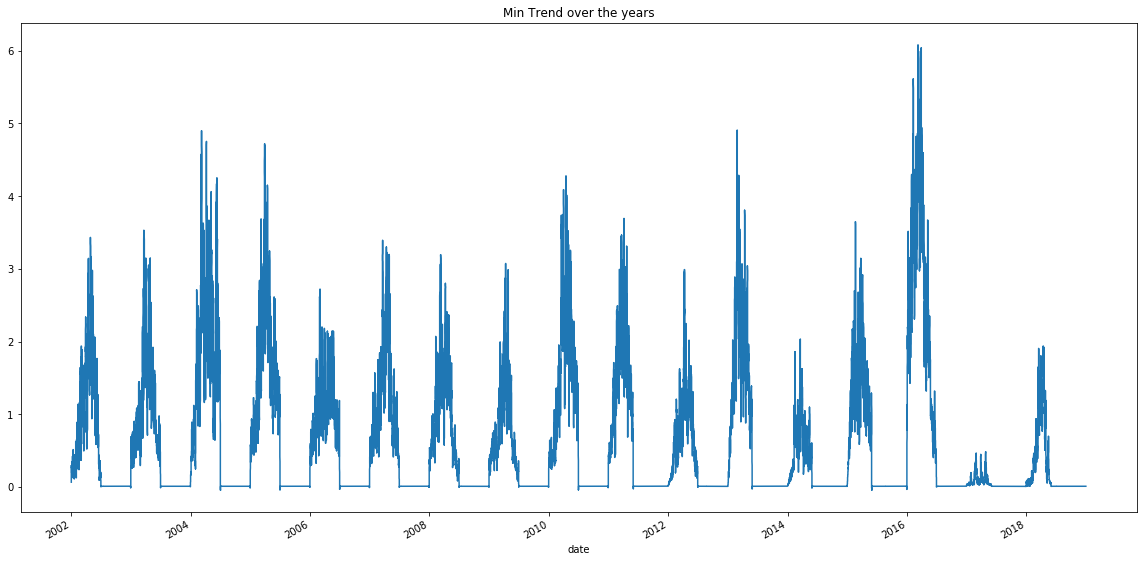

In [15]:
min_trend.plot(figsize=(20,10), title='Min Trend over the years');

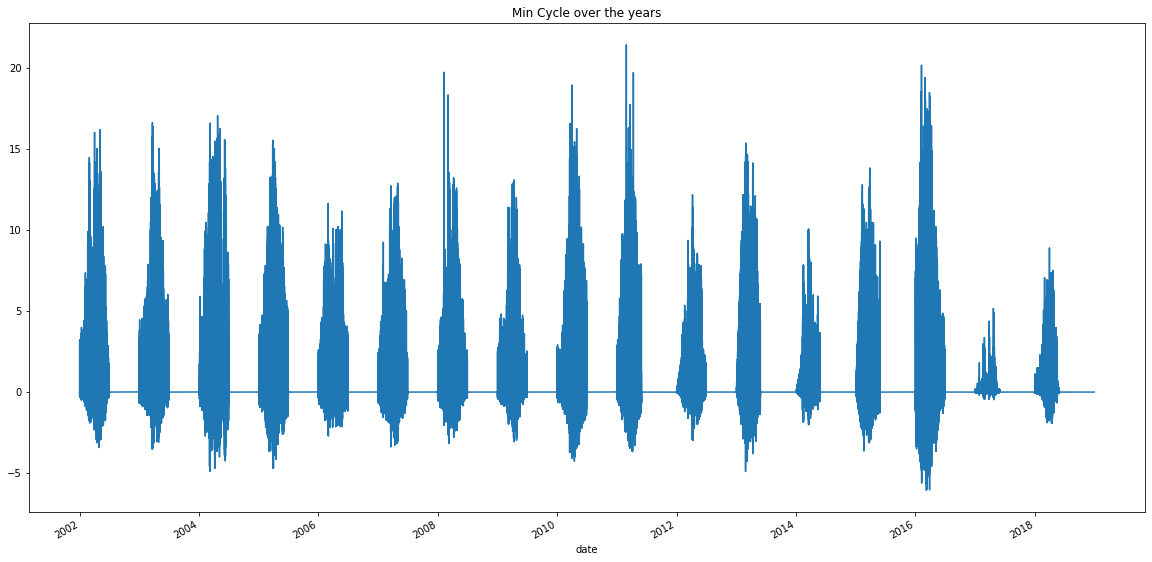

In [16]:
min_cycle.plot(figsize=(20,10), title='Min Cycle over the years');

2017 samples were not reliable, not enough

### Moving Average

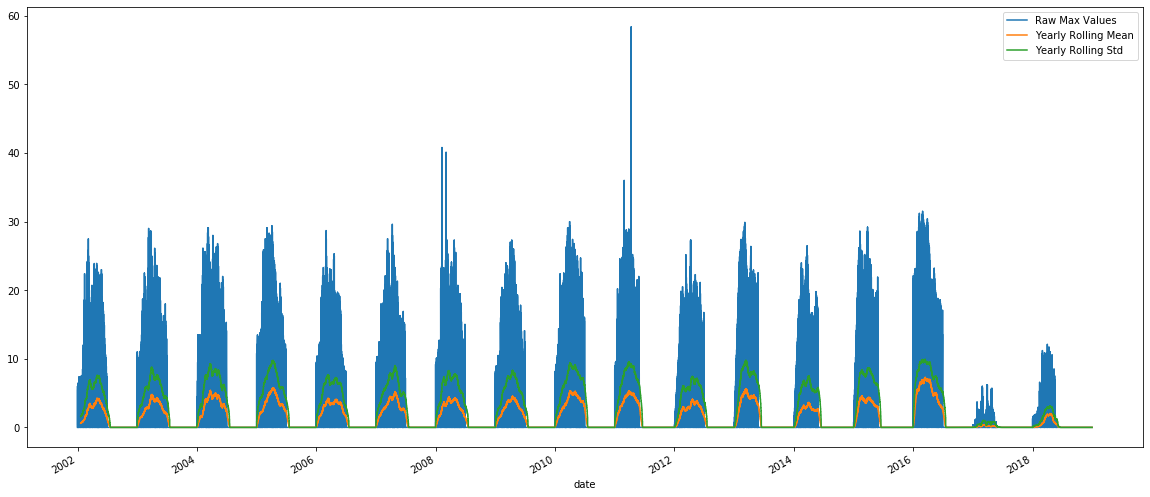

In [17]:
# SMA - Simple Moving Average - Yearly
df['max'].plot(figsize=(20, 9), label='Raw Max Values')
df['max'].rolling(window=365).mean().plot(figsize=(20, 9), label='Yearly Rolling Mean')
df['max'].rolling(window=365).std().plot(figsize=(20, 9), label='Yearly Rolling Std')
plt.legend(loc='upper right');

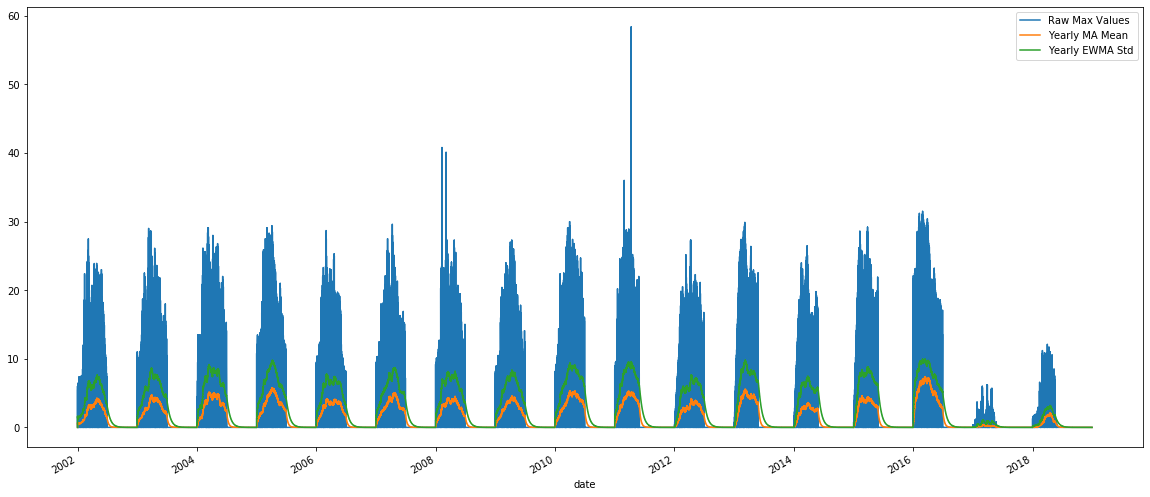

In [18]:
# EWMA - Exponentially-weighted moving average - Yearly
df['max'].plot(figsize=(20, 9), label='Raw Max Values')
df['max'].ewm(span=365).mean().plot(figsize=(20, 9), label='Yearly MA Mean')
df['max'].ewm(span=365).std().plot(figsize=(20, 9), label='Yearly EWMA Std')
plt.legend(loc='upper right');

The SMA and EWMA are pretty much the same. Pay attention to the STD lines, they are wiggle, it means the dataset is not well distributed

### Seasonal Decomposition aka ETS Decomposition

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

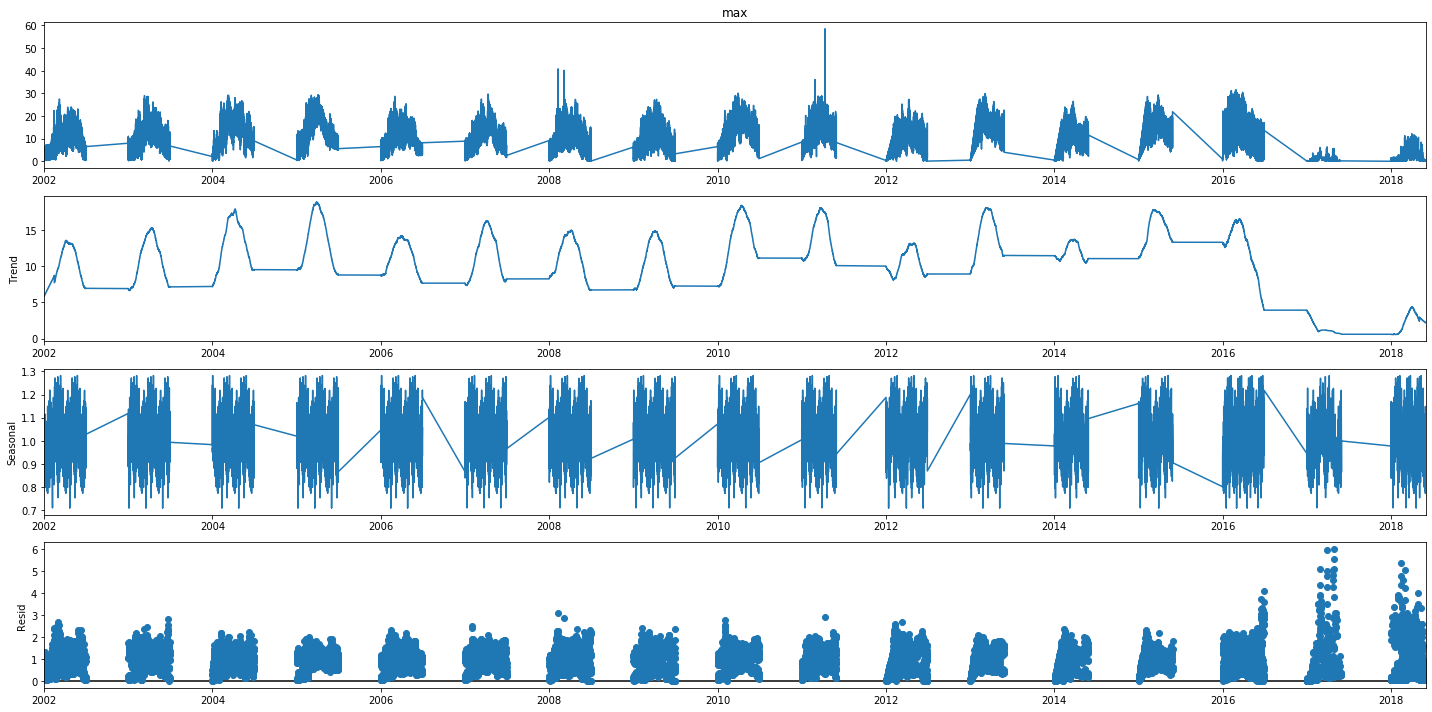

In [20]:
# multiplicative - 365 days on max value

# option 1 to set figsize for plot() used by seasonal_decompose()
plt.rcParams['figure.figsize'] = (20, 10)

result = seasonal_decompose(df[df['max'] > 0.02]['max'], model='multiplicative', period=365, extrapolate_trend=365)
fig = result.plot()  # assign to a variable to work-around double charts in statmodels

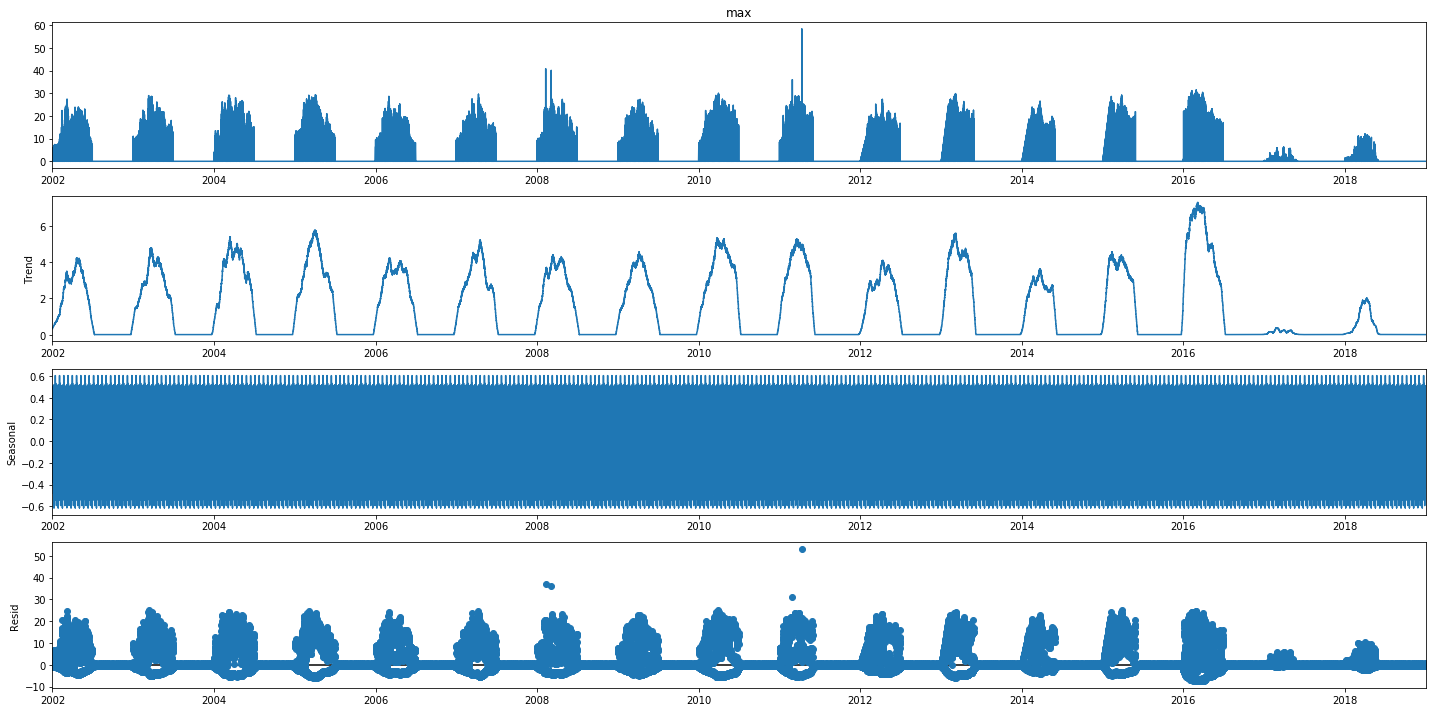

In [21]:
# additive - 365 days on max value
result = seasonal_decompose(df['max'], model='additive', period=365, extrapolate_trend=365)
fig = result.plot()  # assign to a variable to work-around double charts in statmodels

# option 2 to set figsize for plot() used by seasonal_decompose()
fig.set_size_inches(20, 10);

#### Additive model seems to work better in this combined dataset

Multiplicative seasonal adjustment, which is accomplished by multiply or dividing each value of the time series by a seasonal index (a number in the vicinity of 1.0) that represents the percentage of normal typically observed in that season.  

Additive seasonal adjustment is used for time series whose seasonal variations are roughly constant in magnitude, independent of the current average level of the series, would be a candidate for additive seasonal adjustment. In additive seasonal adjustment, each value of a time series is adjusted by adding or subtracting a quantity that represents the absolute amount by which the value in that season of the year tends to be below or above normal, as estimated from past data.

Additive seasonal patterns are somewhat rare in nature, but a series that has a natural multiplicative seasonal pattern is converted to one with an additive seasonal pattern by applying a logarithm transformation to the original data. Therefore, if you are using seasonal adjustment in conjunction with a logarithm transformation, you probably should use additive rather than multiplicative seasonal adjustment.  

The residuals are in big numbers which mean there are many errors in the samples could not be explained in the trend seasonality counter parts

In [22]:
# trend component
result.trend.head()

date
2002-01-01   0.33667
2002-01-01   0.33790
2002-01-01   0.33912
2002-01-01   0.34035
2002-01-01   0.34157
Name: trend, dtype: float64

In [23]:
# seasonal component
result.seasonal.head()

date
2002-01-01   -0.14702
2002-01-01   -0.37770
2002-01-01    0.07904
2002-01-01   -0.29501
2002-01-01    0.04049
Name: seasonal, dtype: float64

In [24]:
# residual component
result.resid.head()

date
2002-01-01   -0.17965
2002-01-01    0.04981
2002-01-01    1.58184
2002-01-01    0.25466
2002-01-01   -0.37206
Name: resid, dtype: float64

#### Since combining samples across stations created noisy. We should analyze by each station:
1. There are 5 critical stations: Ben Trai, An Thuan, Binh Dai, Son Doc, and Loc Thuan, let decomposing max value:

In [25]:
temp_df = df[df['code'] == 'BENTRAI']

# set correct frequency
temp_df.index.freq = 'D'

temp_df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=6209, freq='D')

In [26]:
# Number of samples by years
temp_df.groupby(temp_df.index.year).count()

,code,min,max
date,,,
2002,365,365,365
2003,365,365,365
2004,366,366,366
2005,365,365,365
2006,365,365,365
2007,365,365,365
2008,366,366,366
2009,365,365,365
2010,365,365,365


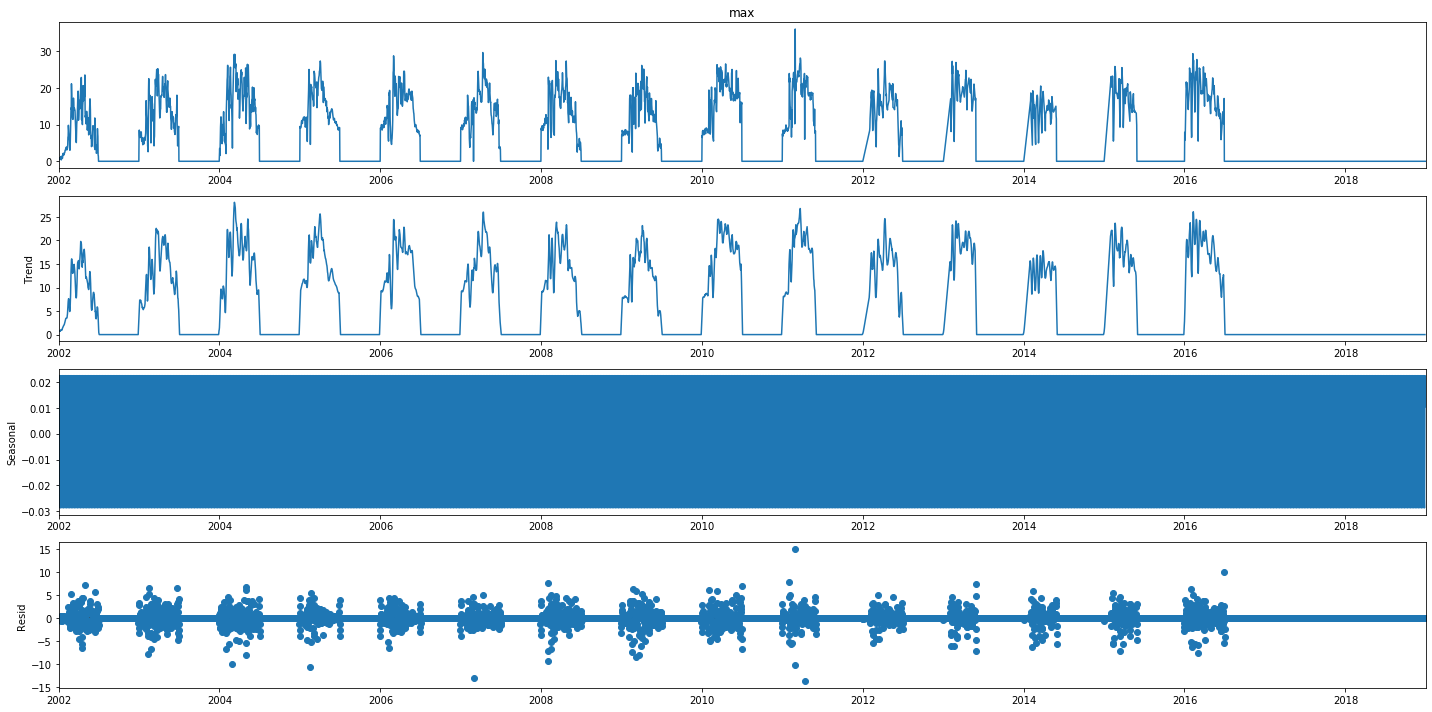

In [27]:
p = seasonal_decompose(temp_df['max'], model='additive').plot()

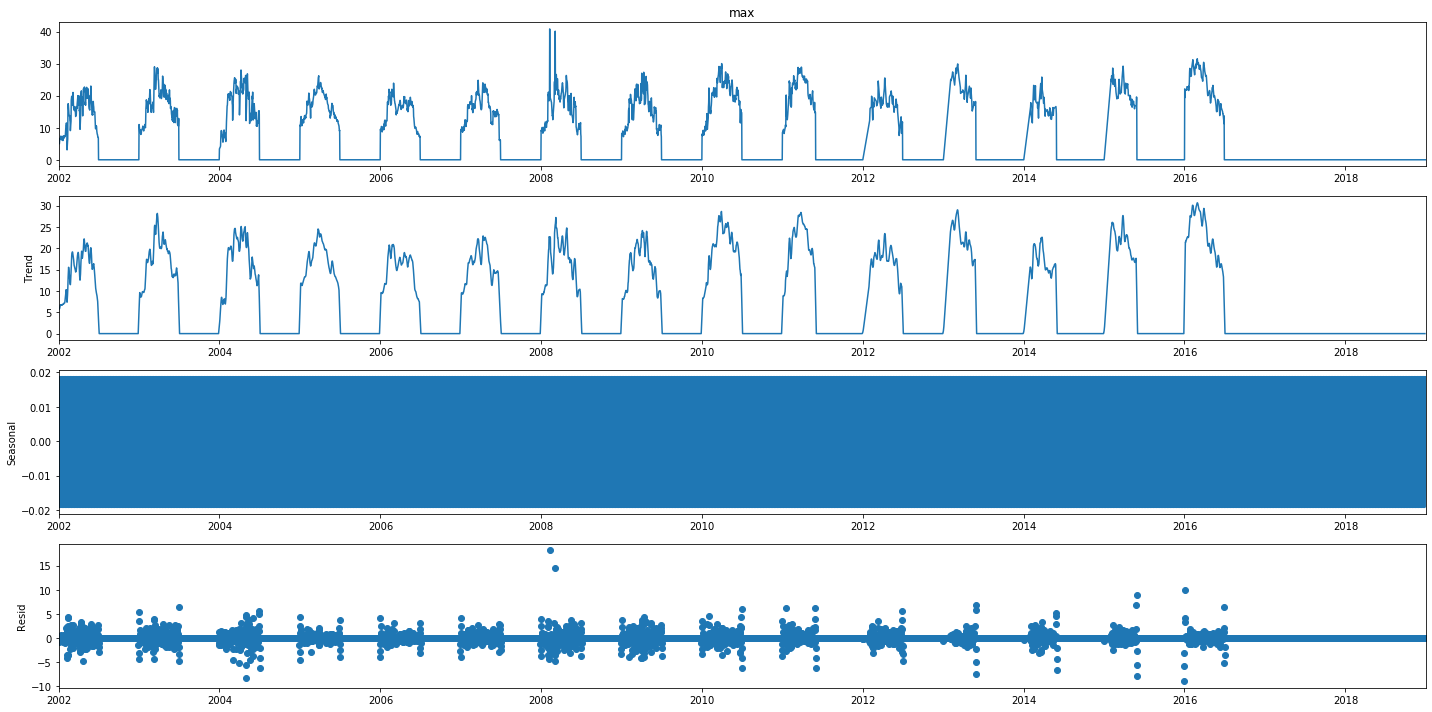

In [28]:
temp_df = df[df['code'] == 'ANTHUAN']
temp_df.index.freq = 'D'
p = seasonal_decompose(temp_df['max'], model='additive').plot()

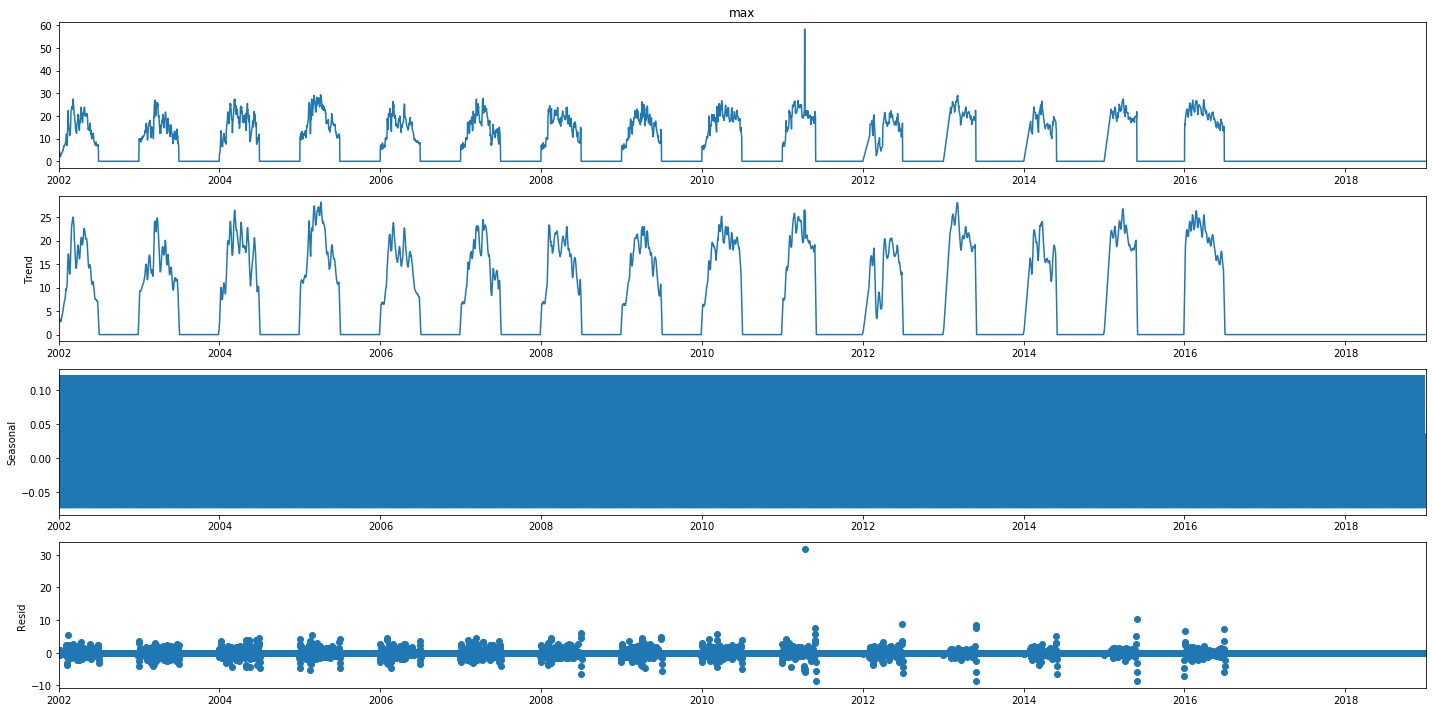

In [29]:
temp_df = df[df['code'] == 'BINHDAI']
temp_df.index.freq = 'D'
p = seasonal_decompose(temp_df['max'], model='additive').plot()

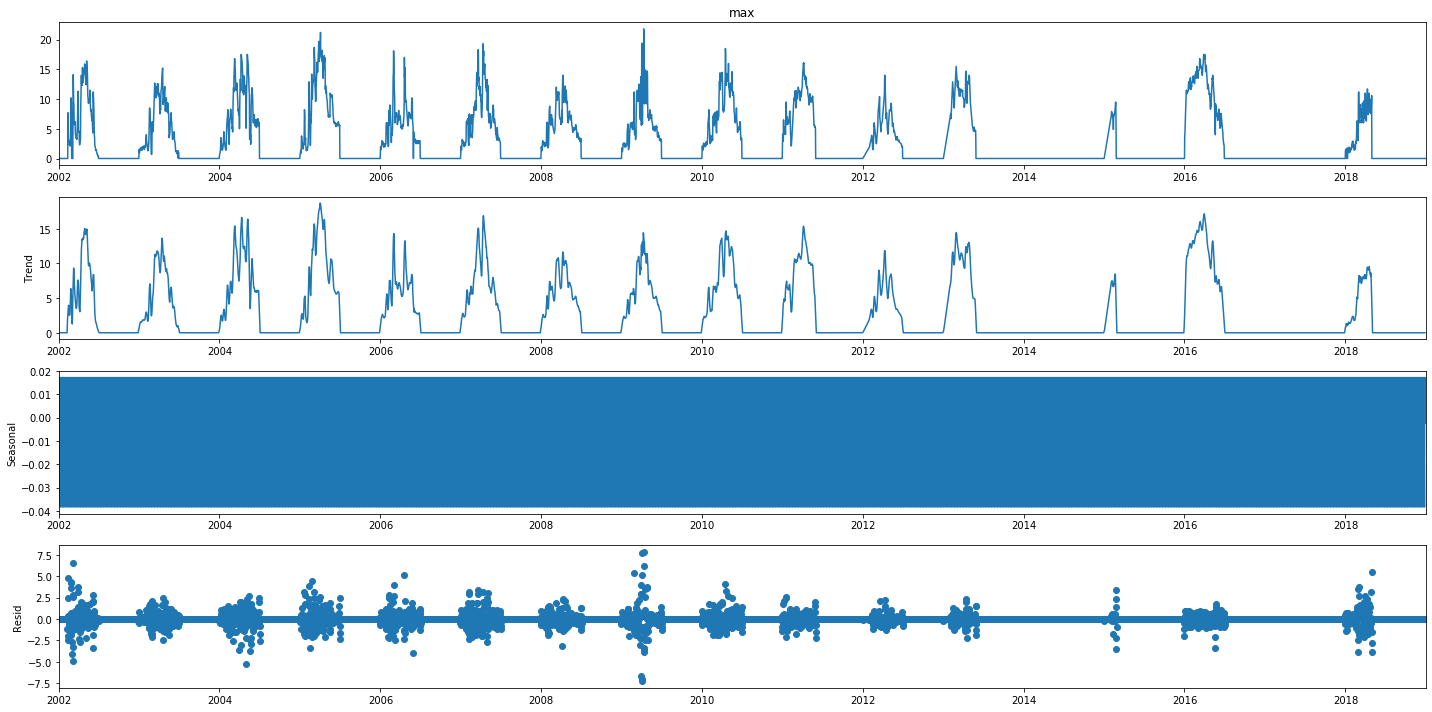

In [30]:
temp_df = df[df['code'] == 'LOCTHUAN']
temp_df.index.freq = 'D'
p = seasonal_decompose(temp_df['max'], model='additive').plot()

##### Since SONDOC has the most samples, we dig more details:

In [31]:
temp_df = df[df['code'] == 'SONDOC']
temp_df.index.freq = 'D'

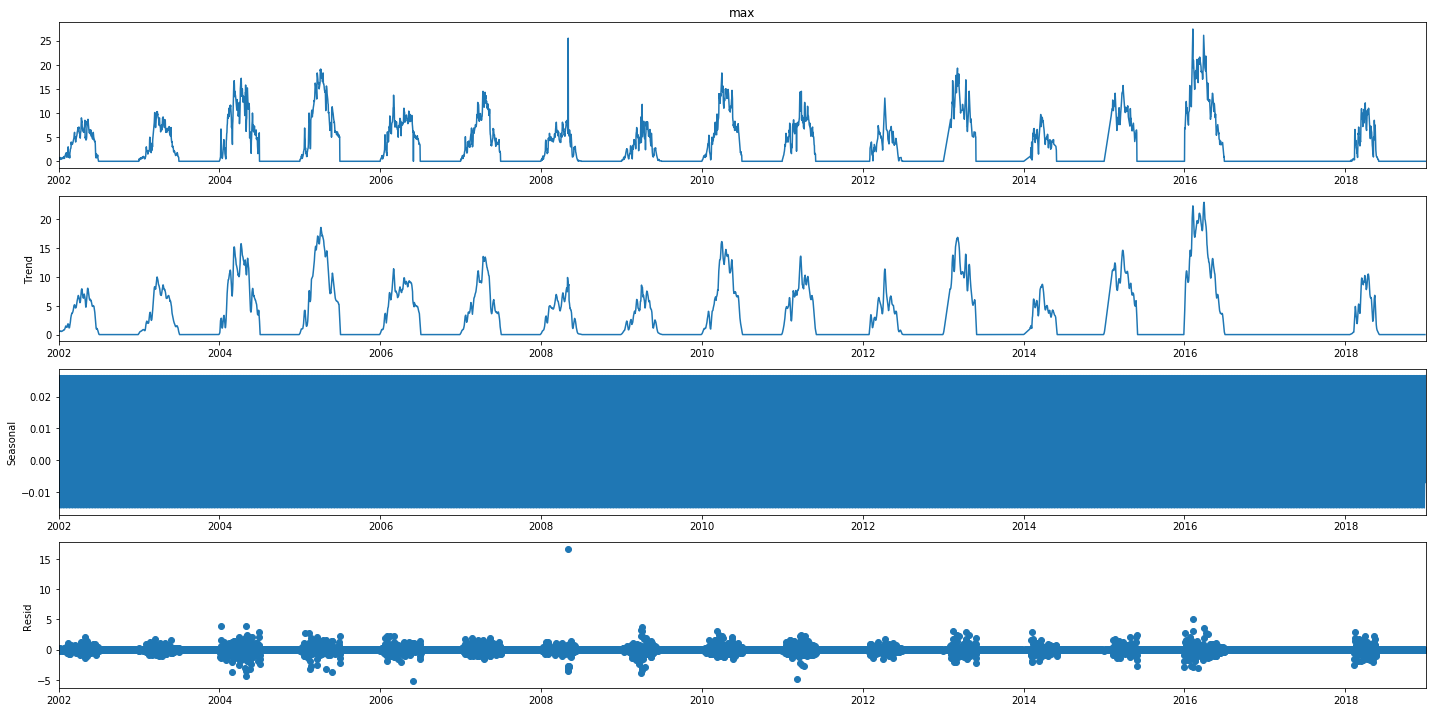

In [32]:
# Use 'additive' model on max
p = seasonal_decompose(temp_df['max'], model='additive').plot()

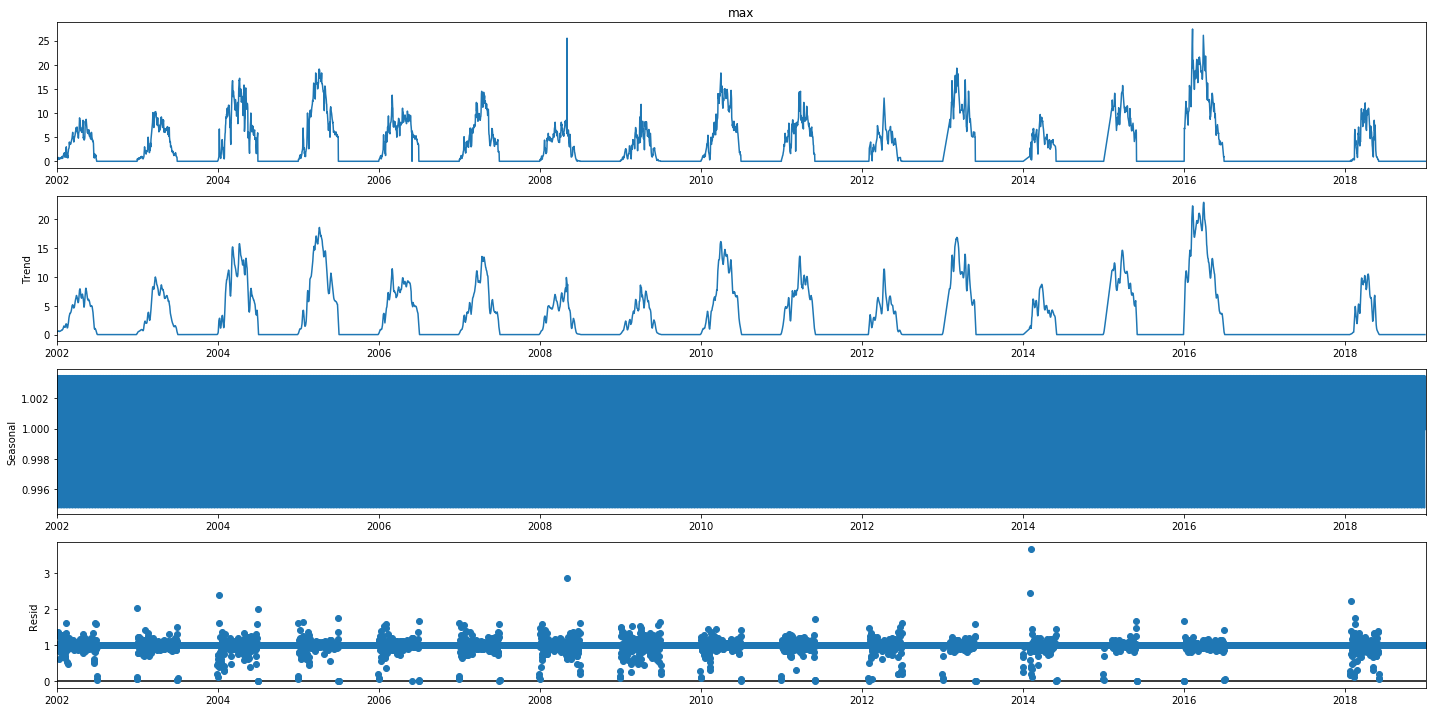

In [33]:
# Use 'multiplicative' model on max
p = seasonal_decompose(temp_df['max'], model='multiplicative').plot()

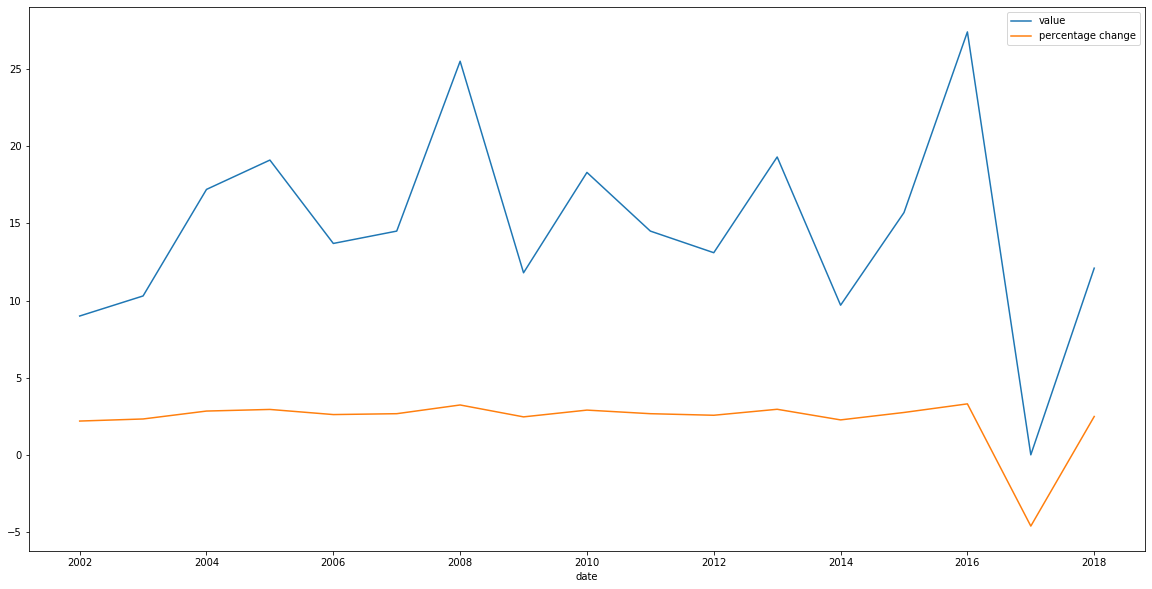

In [34]:
# Visualize value changes (percentage)
plot_df = pd.DataFrame()

# value changes
plot_df['value'] = temp_df['max'].groupby(temp_df.index.year).max()

# percentage changes
plot_df['percentage change'] = np.log(plot_df['value'])

plot_df.plot();

2. The rest of stations have only enough samples for monthly period. There are 4 moderate ones (Tien Thuy, Tan Thieng, Phuoc Long, and Mo Cay) with 2 years of samples while the others have just 1 year of sample. They all have gaps

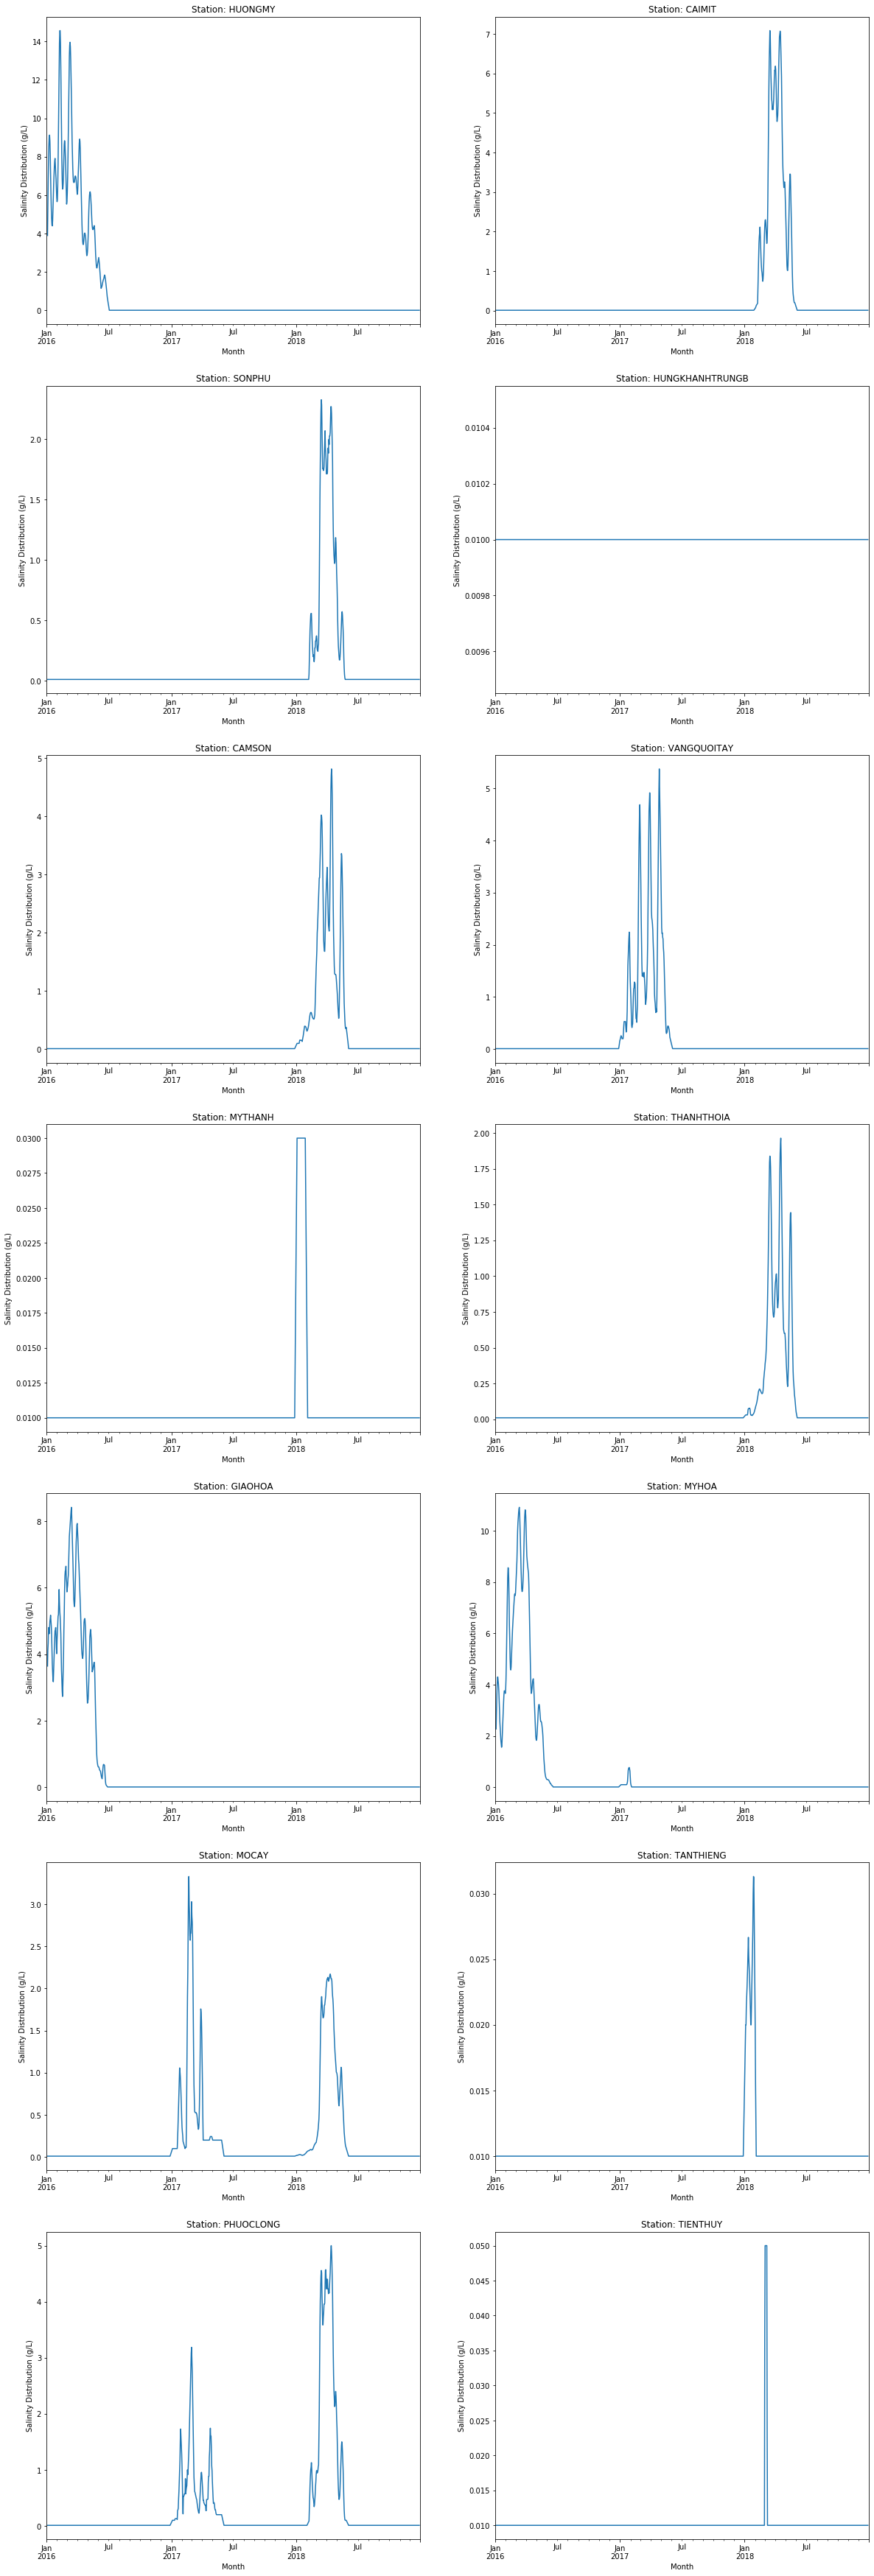

In [35]:
partial_df = df['2016': '2018']

nrows = 7
ncols = 2

# reserve order to the array to iterate from station with lowest samples
station_codes = np.flip(station_count_df.index.to_numpy())

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 9 * nrows))

for row in range(nrows):
    for col in range(ncols):
        ax = axes[row, col]
        station_code = station_codes[row * ncols + col]
        
        temp_df = partial_df.loc[partial_df['code'] == station_code, 'max']
        temp_df.index.freq = 'D'
        
        p = seasonal_decompose(temp_df, model='additive').trend.plot(ax=ax)
        
        ax.set_title(f'Station: {station_code}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Salinity Distribution (g/L)');

These stations samples should not be used in modeling

### Testing for Stationarity

In [36]:
from statsmodels.tsa.stattools import adfuller

In [37]:
# Augmented Dickey-Fuller Test
def adf_check(code, field):
    result = adfuller(df.loc[df['code'] == code, field])

    print(f'Augmented Dickey-Fuller Test of Station {code} on field {field}:')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    
    if result[1] <= 0.05:
        print(f'{field} of station {code} is stationary!!!')
    else:
        print(f'{field} of station {code} is NON-STATIONARY :(')

In [38]:
break_line = 80 * '-'

for station in station_count_df.index.to_numpy():
    print(break_line)
    adf_check(station, 'min')
    print(break_line)
    adf_check(station, 'max')

--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station SONDOC on field min:
ADF Test Statistic: -7.6881784195581515
p-value: 1.4427845917140618e-11
#Lags Used: 34
Number of Observations Used: 6174
min of station SONDOC is stationary!!!
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station SONDOC on field max:
ADF Test Statistic: -7.496448265974498
p-value: 4.3668513995691835e-11
#Lags Used: 33
Number of Observations Used: 6175
max of station SONDOC is stationary!!!
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station LOCTHUAN on field min:
ADF Test Statistic: -6.953130027224111
p-value: 9.578556311222984e-10
#Lags Used: 33
Number of Observations Used: 6175
min of station LOCTHUAN is stationary!!!
--------------------------------------------------------------------------------
Augmented Di

Augmented Dickey-Fuller Test of Station CAMSON on field min:
ADF Test Statistic: -5.81177983550066
p-value: 4.384315535332876e-07
#Lags Used: 34
Number of Observations Used: 6174
min of station CAMSON is stationary!!!
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station CAMSON on field max:
ADF Test Statistic: -6.060909265486292
p-value: 1.213264871651475e-07
#Lags Used: 34
Number of Observations Used: 6174
max of station CAMSON is stationary!!!
--------------------------------------------------------------------------------


/home/kenneth/anaconda3/envs/salinization/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/kenneth/anaconda3/envs/salinization/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


Augmented Dickey-Fuller Test of Station HUNGKHANHTRUNGB on field min:
ADF Test Statistic: nan
p-value: nan
#Lags Used: 0
Number of Observations Used: 6208
min of station HUNGKHANHTRUNGB is NON-STATIONARY :(
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station HUNGKHANHTRUNGB on field max:
ADF Test Statistic: nan
p-value: nan
#Lags Used: 0
Number of Observations Used: 6208
max of station HUNGKHANHTRUNGB is NON-STATIONARY :(
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station SONPHU on field min:
ADF Test Statistic: -10.507897031296904
p-value: 1.0426930558339319e-18
#Lags Used: 34
Number of Observations Used: 6174
min of station SONPHU is stationary!!!
--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test of Station SONPHU on field max:
ADF Test Statistic: -10.427070705923988
p-value: 1.6471378636

#### All 5 critical stations have stationary samples
No need to take any differencing to remove the trend parts for now to see how bad the prediction gonna be. If not, a strategy to fill N/A is needed  
The other stations samples which are none-stationary due to lack of samples

### Autocovariance, Autocorrelation, and Partial Autocorrelation

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols

In [40]:
station_code = 'SONDOC'

In [41]:
station_min_data = df.loc[df['code'] == station_code, 'min']
station_min_data.index.freq = 'D'

station_min_data.head()

date
2002-01-01   0.10000
2002-01-02   0.10000
2002-01-03   0.20000
2002-01-04   0.20000
2002-01-05   0.10000
Freq: D, Name: min, dtype: float64

In [42]:
station_max_data = df.loc[df['code'] == station_code, 'max']
station_max_data.index.freq = 'D'

station_max_data.head()

date
2002-01-01   0.30000
2002-01-02   0.40000
2002-01-03   0.40000
2002-01-04   0.50000
2002-01-05   0.60000
Freq: D, Name: max, dtype: float64

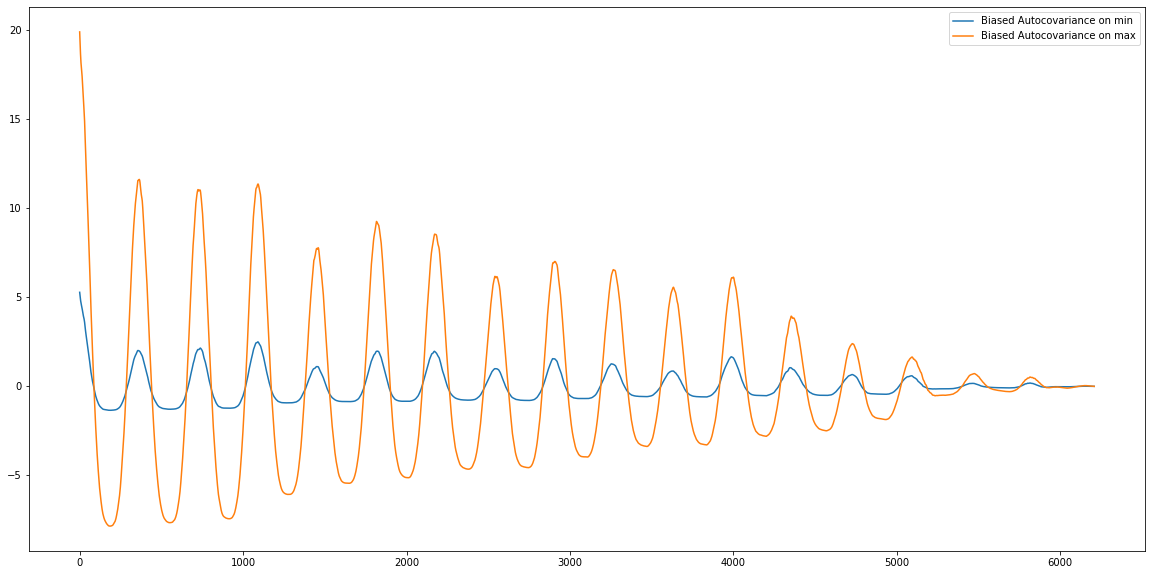

In [43]:
# Biased Autocovariance
plt.plot(acovf(station_min_data, fft=True), label='Biased Autocovariance on min')
plt.plot(acovf(station_max_data, fft=True), label='Biased Autocovariance on max')
plt.legend();

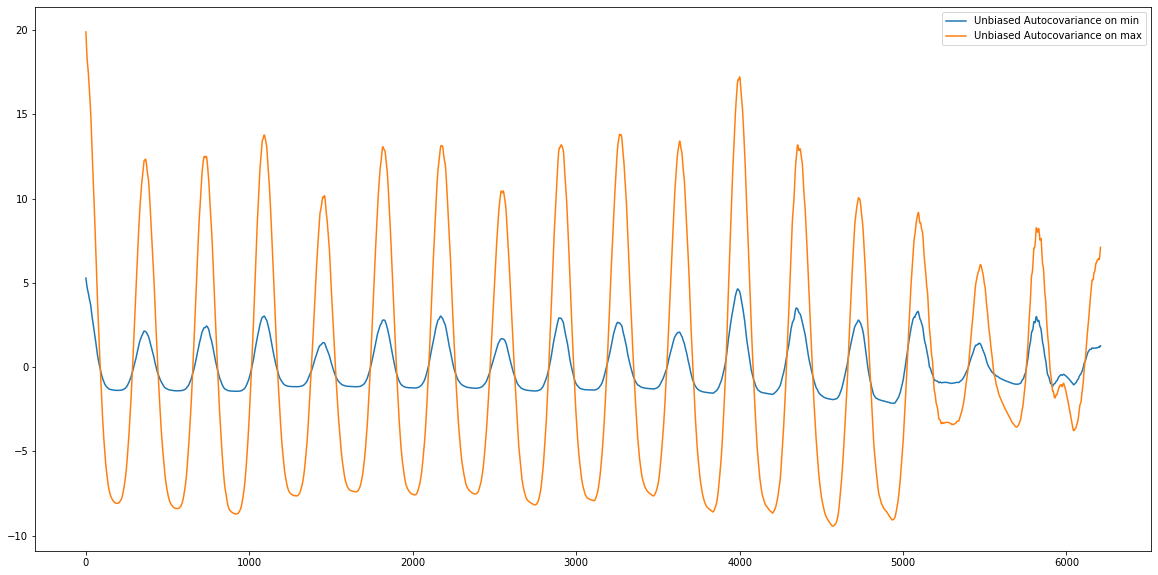

In [44]:
# Unbiased Autocovariance
plt.plot(acovf(station_min_data, fft=True, unbiased=True), label='Unbiased Autocovariance on min')
plt.plot(acovf(station_max_data, fft=True, unbiased=True), label='Unbiased Autocovariance on max')
plt.legend();

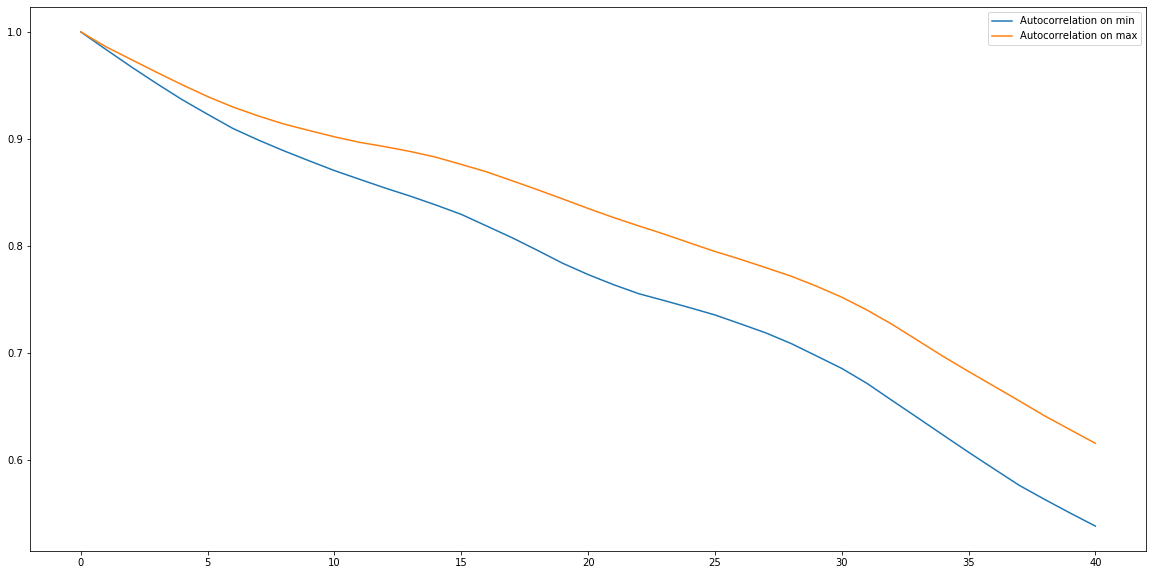

In [45]:
# Autocorrelation
plt.plot(acf(station_min_data, fft=True, unbiased=True), label='Autocorrelation on min')
plt.plot(acf(station_max_data, fft=True, unbiased=True), label='Autocorrelation on max')
plt.legend();

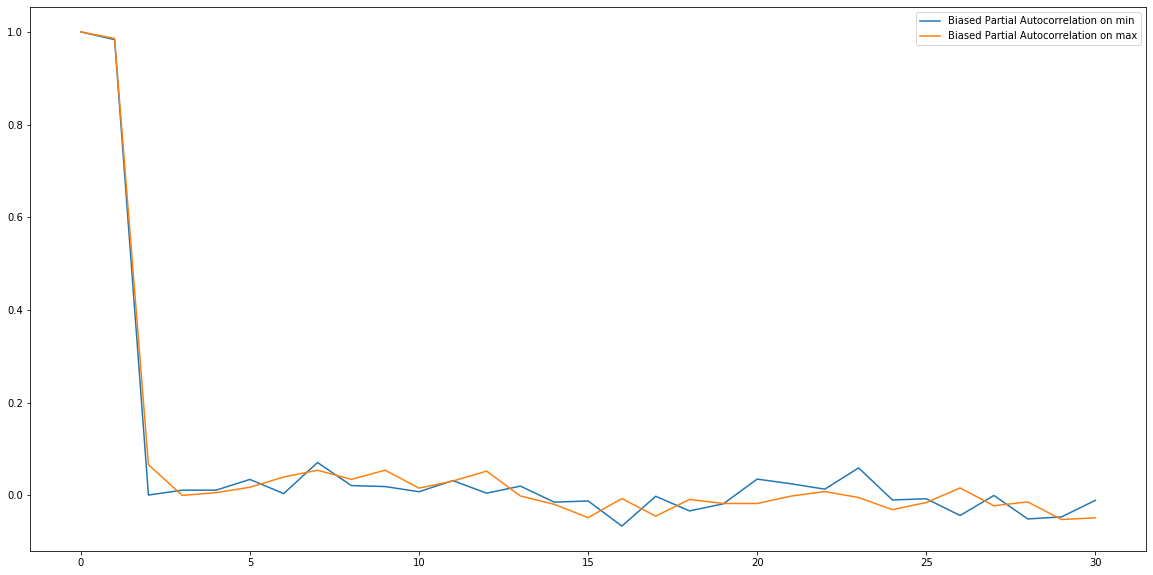

In [46]:
# Biased Partial Autocorrelation using 'mle' - maximum likelihood estimation - with Yule-Walker
plt.plot(pacf_yw(station_min_data, nlags=30, method='mle'), label='Biased Partial Autocorrelation on min')
plt.plot(pacf_yw(station_max_data, nlags=30, method='mle'), label='Biased Partial Autocorrelation on max')
plt.legend();

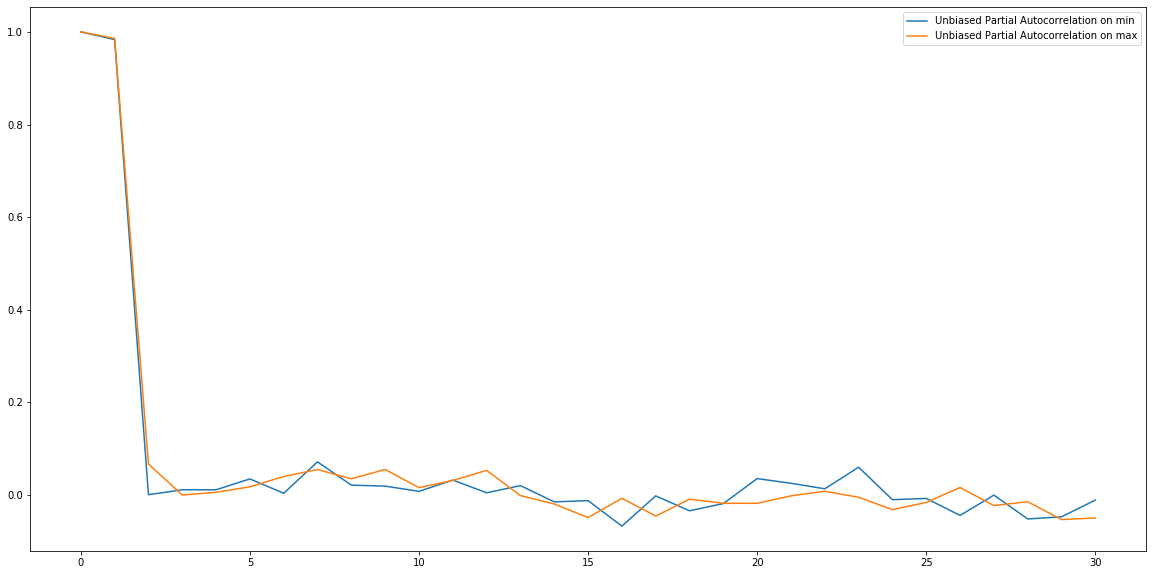

In [47]:
# Unbiased Partial Autocorrelation
plt.plot(pacf_yw(station_min_data, nlags=30, method='unbiased'), label='Unbiased Partial Autocorrelation on min')
plt.plot(pacf_yw(station_max_data, nlags=30, method='unbiased'), label='Unbiased Partial Autocorrelation on max')
plt.legend();

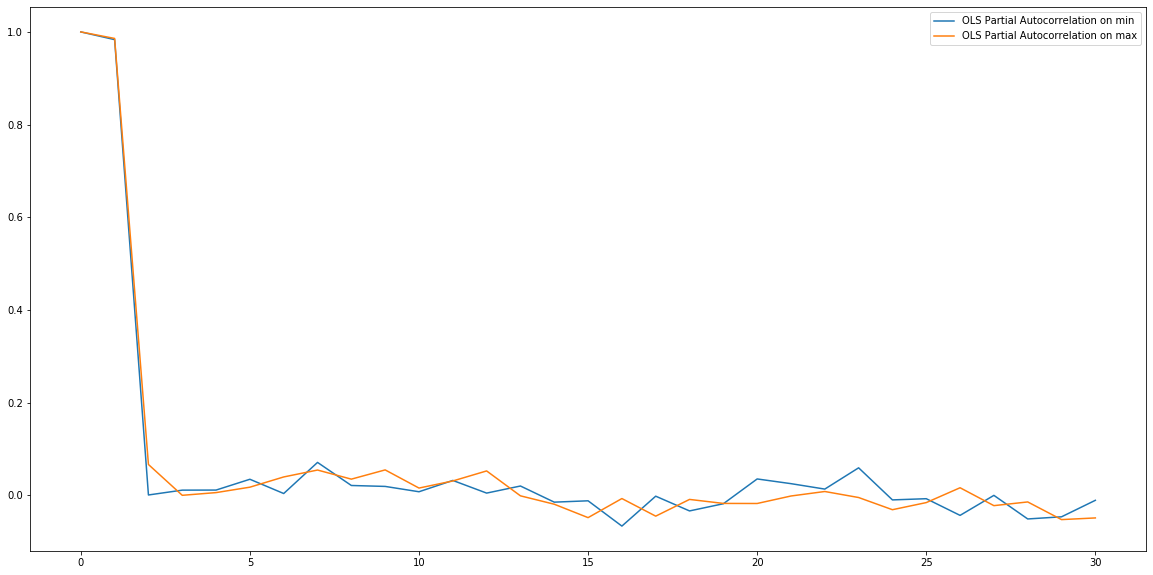

In [48]:
# Partial Autocorrelation using ordinary least squares (OLS) estimates for each lag instead of Yule-Walker.
plt.plot(pacf_ols(station_min_data, nlags=30), label='OLS Partial Autocorrelation on min')
plt.plot(pacf_ols(station_max_data, nlags=30), label='OLS Partial Autocorrelation on max')
plt.legend();

## Plotting
The arrays returned by <tt>.acf()</tt> and <tt>.pacf_yw()</tt> show the magnitude of the autocorrelation for a given $y$ at time $t$. let's look at the data itself for evidence of autocorrelation.

Pandas has a built-in plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way:

In [49]:
from pandas.plotting import lag_plot

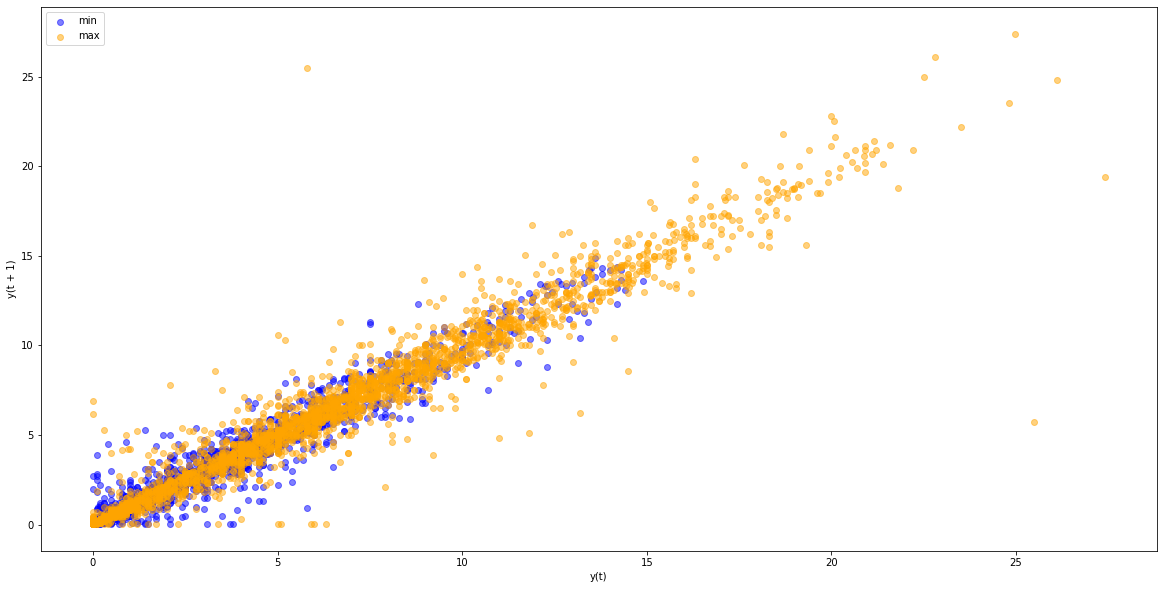

In [50]:
ax = lag_plot(station_min_data, label='min', c='blue', alpha=0.5);
lag_plot(station_max_data, label='max', ax=ax, c='orange', alpha=0.5);
plt.legend(loc='upper left');

Visually this shows evidence of a very strong autocorrelation; as $y_t$ values increase, nearby (lagged) values also increase.

In [51]:
def plot_autocorrelation(plot_func, title):
    nrows = 5
    ncols = 2

    station_codes = station_count_df.index.to_numpy()

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 9 * nrows))

    for row in range(nrows):
        station_code = station_codes[row]

        ax = axes[row, 0]
        fig = plot_func(df.loc[df['code'] == station_code, 'min'], ax=ax, title=f'{title} - {station_code} on min')

        ax = axes[row, 1]
        fig = plot_func(df.loc[df['code'] == station_code, 'max'], ax=ax, title=f'{title} - {station_code} on max')

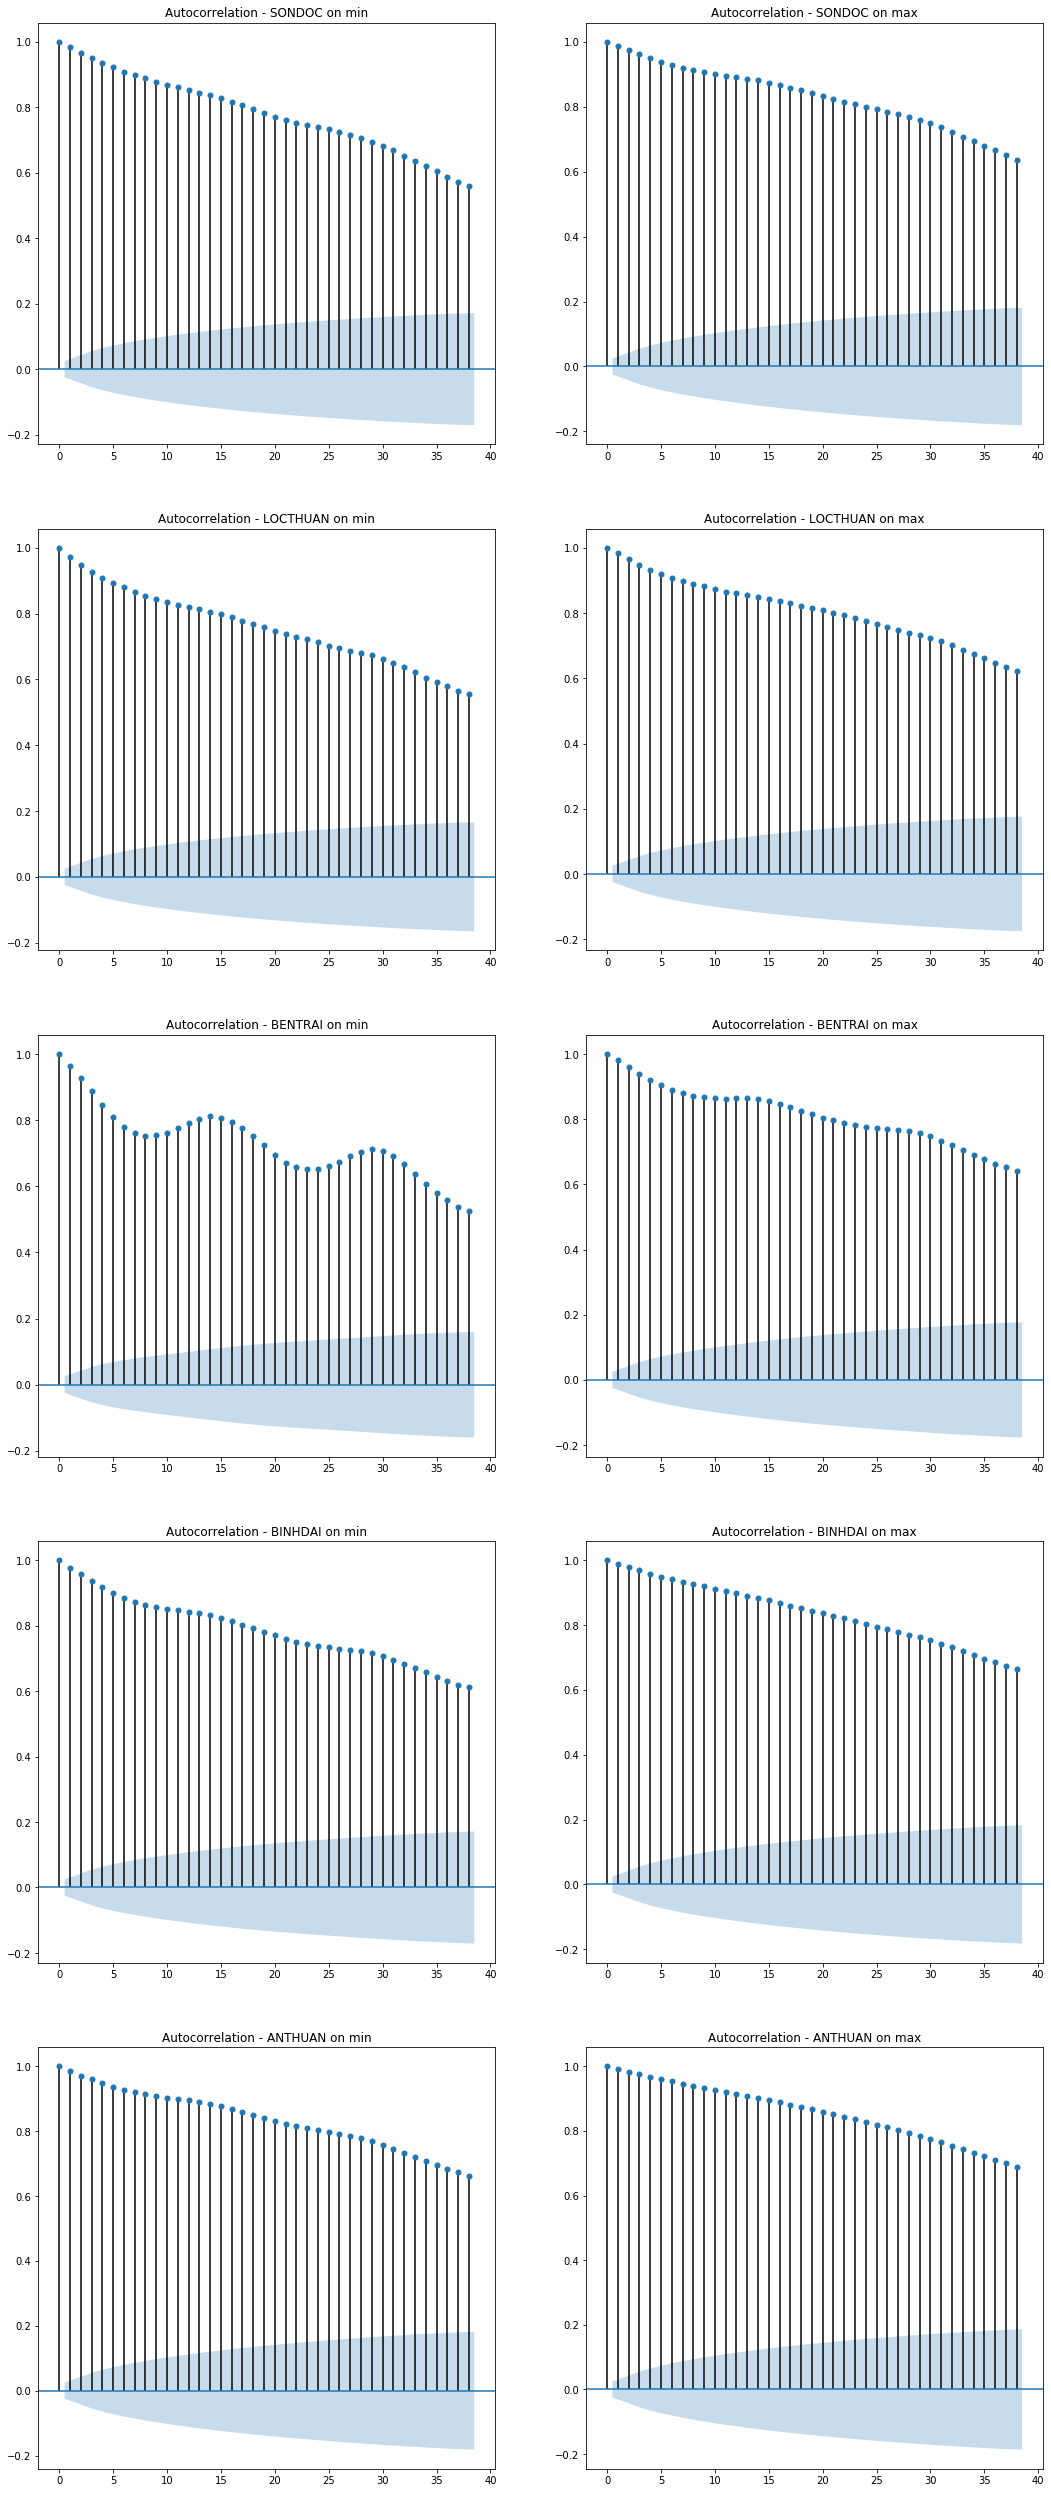

In [52]:
# Autocorrelation
plot_autocorrelation(plot_acf, 'Autocorrelation')

#### Both min and max values from 5 critical stations have gradual decline, not sharp drop, in their autocorelation plots which indicate the data is non-stationary  
Use AR (Auto Regressive) or MA (Moving Average) components for the ARIMA model?

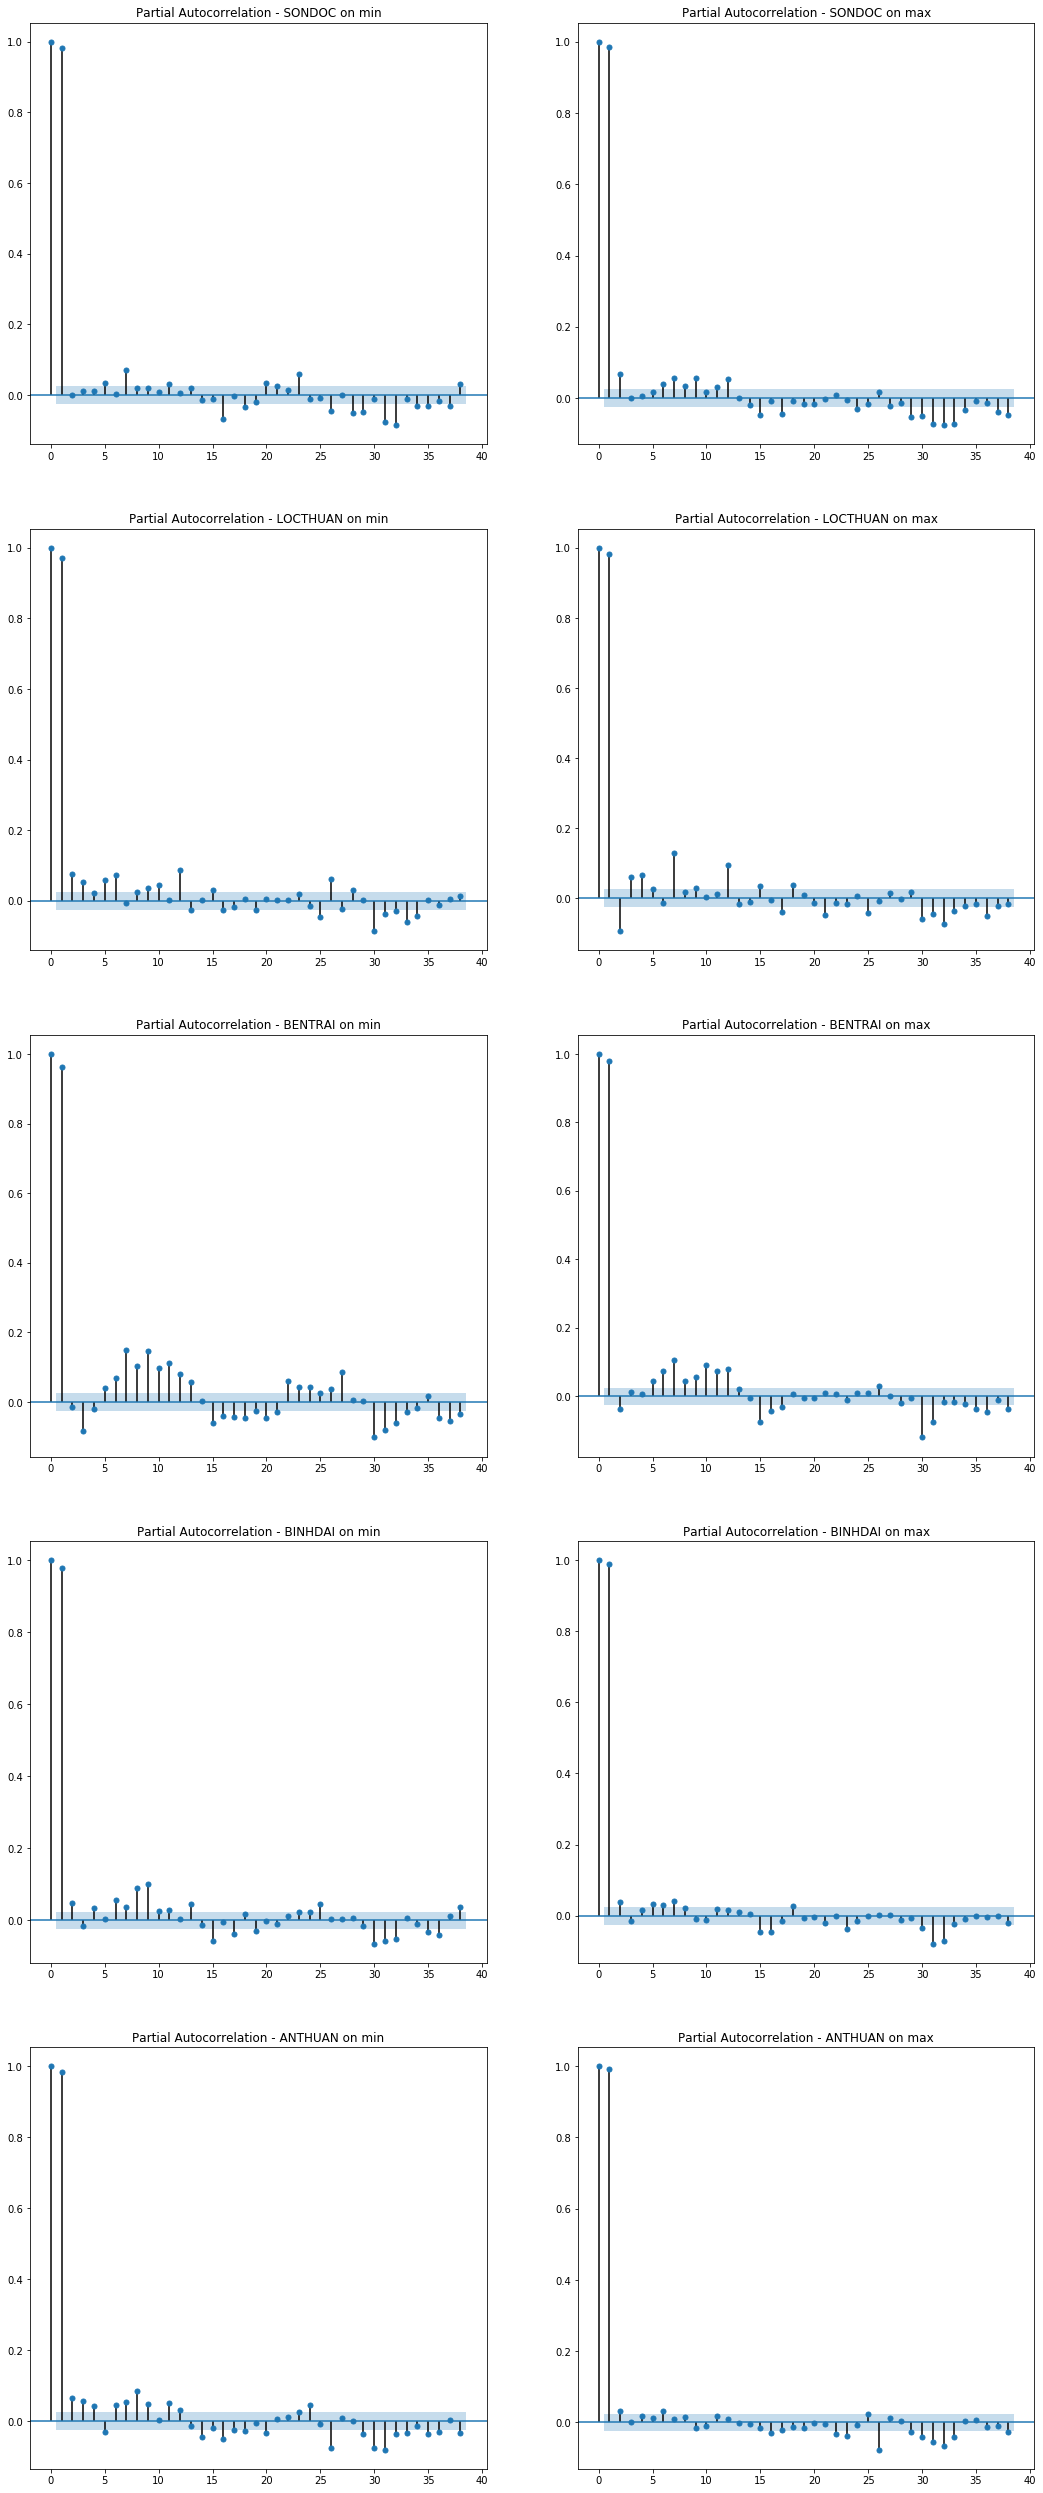

In [53]:
# Partial Autocorrelation
plot_autocorrelation(plot_pacf, 'Partial Autocorrelation')

#### Both min and max values from 5 critical stations have sharp drop in their partial autocorelation plots  
Use Auto-Regression after the K number of lags in the ARIMA models (AR component)

## Samples for other stations could be used since they also have advantage due to lack of longer historical data. Further explorations are needed to pick the right prediction models  
See 'Principles and risks of forecasting' by Robert Nau  
Additional reading is preferable: https://people.duke.edu/~rnau/411home.htm